In [2]:
import xml.etree.ElementTree as ET
import os
from typing import List
from functools import reduce
from calendar import monthrange
import random
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
import time

## Gender-neutral adjectives describing people

In [4]:
from bs4 import BeautifulSoup
import urllib.request as urllib2
import csv

In [5]:
url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
file = urllib2.urlopen(url)
html = file.read()
file.close()
soup = BeautifulSoup(html)

In [6]:
adj = soup.find_all(attrs={"class": "wordlist-item"})

In [7]:
adjs = [x.contents[0] for x in adj]

In [8]:
adjs[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [9]:
with open('adjectives.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(adjs)

In [10]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

# Data Parsing and Processing

In [11]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [12]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [13]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [14]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


995.522246

In [15]:
len(all_)

1685787

# Saving files locally and loading

In [18]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [19]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [20]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

# Process by descriptor

In [16]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

16.321060999999986

In [17]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [17]:
computers = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Computers and the Internet'][1]))

In [18]:
politics = list(filter(lambda x: 'Computers and the Internet' not in x.descriptors, \
                        alld['Politics and Government'][1]))

In [19]:
travel = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Travel and Vacations'][1]))

In [20]:
len(computers), len(politics), len(travel)

(5825, 10316, 6499)

# Training Word Embeddings

In [21]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [22]:
import nltk

In [23]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [24]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

123.59515700000009

In [396]:
t = time.process_time()
mcomp = getw2v(computers)
time.process_time() - t

74.33046300000024

In [26]:
t = time.process_time()
mtrav = getw2v(travel)
time.process_time() - t

108.69644400000016

In [69]:
mpol.wv.most_similar(positive=['approve'], topn=3)

[('submit', 0.8341895937919617),
 ('propose', 0.8119412660598755),
 ('enact', 0.7948086857795715)]

In [70]:
mcomp.wv.most_similar(positive=['approve'], topn=3)

[('impose', 0.7918925285339355),
 ('overturn', 0.7905616760253906),
 ('amend', 0.7885333895683289)]

In [71]:
mtrav.wv.most_similar(positive=['approve'], topn=3)

[('declare', 0.8011578321456909),
 ('succeed', 0.7921991348266602),
 ('reconsider', 0.7868716716766357)]

# Summarization

In [27]:
from gensim.summarization.summarizer import summarize
from gensim.models import LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [28]:
def getsummaries(category):
    s = []
    for i in range(len(category)):
        try:
            s.append(summarize(category[i].text))
        except:
            print(i)
    return s

In [29]:
t = time.process_time()
summaries_pol = getsummaries(politics)
time.process_time() - t

1543
3635
4911
5714
6766
7321
8633
9367


149.37134600000013

In [386]:
t = time.process_time()
summaries_comp = getsummaries(computers)
time.process_time() - t

1018
1258
1830
3182
3296
4812
5102


98.22116499999902

In [31]:
t = time.process_time()
summaries_trav = getsummaries(travel)
time.process_time() - t

130.53599900000017

In [33]:
def getw2v_s(sums):
    sentences = []
    for t in sums:
        sentences += nltk.sent_tokenize(t)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [34]:
mpols = getw2v_s(summaries_pol)

In [387]:
mcomps = getw2v_s(summaries_comp)

In [36]:
mtravs = getw2v_s(summaries_trav)

In [40]:
import text_summarizer

In [41]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/mayjiang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayjiang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
import requests

In [44]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [45]:
embedding_model = text_summarizer.centroid_word_embeddings.load_gensim_embedding_model('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [95]:
centroid_word_embedding_summarizer = text_summarizer.CentroidWordEmbeddingsSummarizer(embedding_model, preprocess_type='nltk')


In [403]:
centroid_word_embedding_summarizer.summarize(text, limit=50)

'Morpheus and Neo stand in a sparring program.\nShe is the one who made the Prophecy of the One and that Morpheus would be the one to find him.\nCypher returns to the Nebuchadnezzar before Trinity, Neo, Switch and Apoc.\n"He\'s killing him," says Trinity.\nIn the Matrix, Neo opens his eyes.'

In [141]:
import requests
import text_summarizer
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
centroid_summary = centroid_summarizer.summarize(text, limit=500)

In [145]:
centroid_summary = centroid_summarizer.summarize(text, limit_type = 'sentence', limit=20)

In [146]:
centroid_summary

'Morpheus, who is above Neo in the walls, breaks through the wall and lands on the agent, yelling to Trinity to get Neo out of the building.'

In [97]:
centroid_word_embedding_summary

"Argentina!''\n''I believe in an Argentina without unemployment, without misery,'' he said in a speech that appeared to have been quickly drafted and had little rhetorical flourish.He wrapped himself in the legacies of Gen. Juan Domingo Perón, the  dictator who founded the Justicialist Party in the 1940's as a vehicle for big labor, and the Mothers of the Plaza de Mayo, a group that still demonstrates demanding information about the tens of thousands of people who disappeared during military rule from 1976 to 1983.But Mr. Rodríguez Saá stopped well short of a complete break with previous government policy.\nUsually scrip loses value over time in what some economists call a ''backdoor devaluation.\nVoters will choose one candidate, but the candidate getting the most votes will not necessarily win."

In [85]:
len(nltk.word_tokenize(centroid_word_embedding_summary))

143

In [100]:
t = time.process_time()
centroid_pol_summaries = [centroid_word_embedding_summarizer.summarize(text.text, limit=500) for text in politics]
time.process_time() - t

302.81612900000005

In [124]:
t = time.process_time()
centroid_trav_summaries = [centroid_word_embedding_summarizer.summarize(text.text, limit=500) for text in travel]
time.process_time() - t

284.90347999999994

In [126]:
t = time.process_time()
centroid_comp_summaries = [centroid_word_embedding_summarizer.summarize(text.text, limit=500) for text in computers]
time.process_time() - t

196.42342300000018

In [102]:
mpols_centroid = getw2v_s(centroid_pol_summaries)

In [127]:
mcomps_centroid = getw2v_s(centroid_comp_summaries)

In [128]:
mtravs_centroid = getw2v_s(centroid_trav_summaries)

(58, 100)


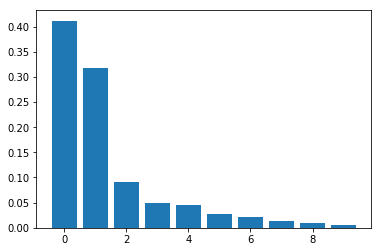

In [109]:
gpols_centroid = getg(mpols_centroid)

(44, 100)


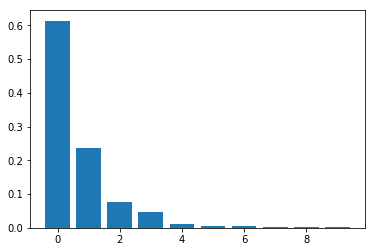

In [129]:
gcomps_centroid = getg(mcomps_centroid)

(66, 100)


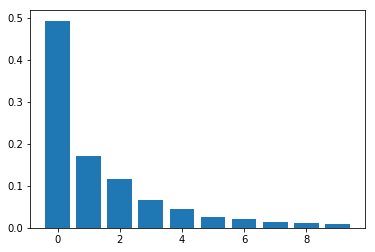

In [130]:
gtravs_centroid = getg(mtravs_centroid)

In [112]:
res = sorted([(x, gproj(gpols_centroid, mpols_centroid, x)) for x in filter(lambda x: x in mpols_centroid.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

she                  -2.2710788249969482 		 he                   2.356893301010132
pretty               -0.508688747882843 		 leadership           1.8383127450942993
guy                  -0.30442196130752563 		 strong               1.207552433013916
mother               -0.3039940297603607 		 politician           0.8111317157745361
dressed              -0.09755730628967285 		 professor            0.705872118473053
smart                -0.09026387333869934 		 architect            0.42393848299980164
blond                -0.08173473924398422 		 scientist            0.15896250307559967
woman                -0.07382756471633911 		 physician            0.1393873393535614
male                 -0.06741078943014145 		 capable              0.11589368432760239
brilliant            -0.05333647131919861 		 philosopher          0.07245338708162308
sewing               -0.015276863239705563 		 man                  0.07010260969400406
handsome             -0.013255850411951542 		 surgeon             

In [123]:
bias(gpols_centroid, mpols_centroid, proflist), bias(gpols, mpols, proflist)

(0.9482668682883479, 0.6022038179460508)

In [139]:
adjectives

['able',
 'abnormal',
 'above average',
 'absent-minded',
 'adventurous',
 'affectionate',
 'agile',
 'agreeable',
 'alert',
 'amazing',
 'ambitious',
 'amiable',
 'amusing',
 'analytical',
 'angelic',
 'apathetic',
 'apprehensive',
 'ardent',
 'artificial',
 'artistic',
 'assertive',
 'attentive',
 'average',
 'awesome',
 'awful',
 'balanced',
 'beautiful',
 'below average',
 'beneficent',
 'blue',
 'blunt',
 'boisterous',
 'brave',
 'bright',
 'brilliant',
 'buff',
 'callous',
 'candid',
 'cantankerous',
 'capable',
 'careful',
 'careless',
 'caustic',
 'cautious',
 'charming',
 'cheerful',
 'chic',
 'childish',
 'childlike',
 'churlish',
 'circumspect',
 'civil',
 'clean',
 'clever',
 'clumsy',
 'coherent',
 'cold',
 'competent',
 'composed',
 'conceited',
 'condescending',
 'confident',
 'confused',
 'conscientious',
 'considerate',
 'content',
 'cool',
 'cool-headed',
 'cooperative',
 'cordial',
 'courageous',
 'cowardly',
 'crabby',
 'crafty',
 'cranky',
 'crass',
 'critical',
 '

In [137]:
bias(gtravs_centroid, mtravs_centroid, proflist), bias(gtravs, mtravs, proflist)

(0.4050998646040163, 0.13439693361364366)

In [138]:
bias(gcomps_centroid, mcomps_centroid, proflist), bias(gcomps, mcomps, proflist)

(1.8559659211923412, 0.4531655633919334)

# Measuring Bias

In [106]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())

In [107]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import bar

In [108]:
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

In [51]:
pairs[:5]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['catholic_priest', 'nun'],
 ['dad', 'mom'],
 ['men', 'women']]

## For Politics

In [104]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    bar(range(10), p.explained_variance_ratio_)
    print(matrix.shape)
    return p.components_[0]

(76, 100)


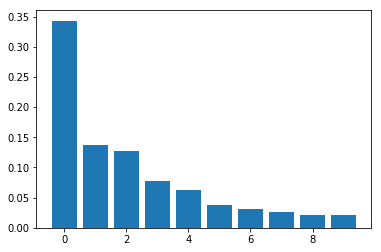

In [77]:
gpol = getg(mpol)

(74, 100)


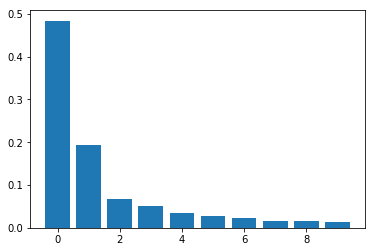

In [397]:
gcomp = getg(mcomp)

(86, 100)


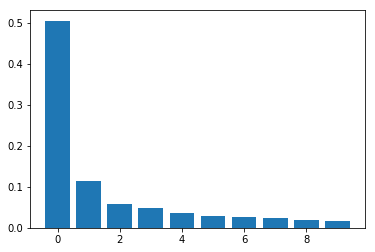

In [133]:
gtrav = getg(mtrav)

(76, 100)


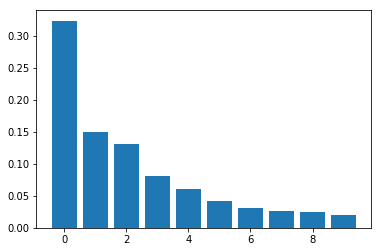

In [122]:
gpols = getg(mpol)

(54, 100)


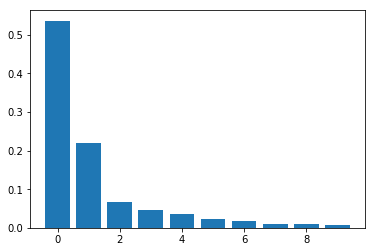

In [394]:
gcomps = getg(mcomps)

(62, 100)


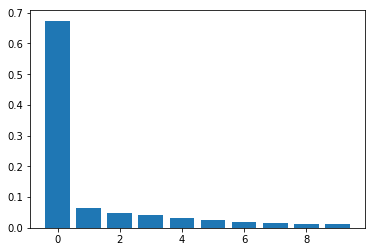

In [135]:
gtravs = getg(mtravs)

<BarContainer object of 10 artists>

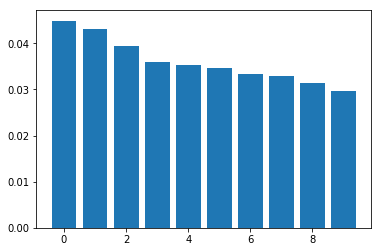

In [96]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(76,100))
bar(range(10), pca_r.explained_variance_ratio_)

In [111]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/np.linalg.norm(g)
    return p

In [110]:
wordlist = ['he', 'she', 'doctor', 'nurse', 'man', 'woman', 'male', 'female', 'politician', 'guy', \
            'scientist', 'teacher', 'professor', 'mother', 'pretty', 'handsome', 'strong', 'coward', \
            'timid', 'leadership', 'blond', 'lovely', 'petite', 'surgeon', 'physician', 'shopkeeper', \
            'cooking', 'sewing', 'chuckle', 'sassy', 'lanky', 'competent', 'brilliant', 'capable', 'smart', \
            'intelligent', 'incompetent', 'librarian', 'cosmetics', 'maid', 'clever', 'dressed', 'captain', \
            'nanny', 'philosopher', 'architect', 'financier', 'warrior', 'magician', 'housekeeper', 'homemaker']

In [117]:
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in mpol.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

man                  -3.7426586151123047 		 she                  6.507950782775879
he                   -3.2389204502105713 		 woman                3.978196859359741
leadership           -2.6054000854492188 		 female               2.1559529304504395
professor            -2.5416016578674316 		 male                 2.0371978282928467
politician           -2.009556293487549 		 mother               1.9487175941467285
scientist            -1.995765209197998 		 doctor               1.373782992362976
architect            -1.6636126041412354 		 teacher              1.095907211303711
guy                  -1.236844539642334 		 pretty               1.0189235210418701
captain              -0.7500171065330505 		 dressed              0.6161187887191772
strong               -0.729799747467041 		 blond                0.49705949425697327
financier            -0.48084181547164917 		 intelligent          0.4610220789909363
warrior              -0.3460354208946228 		 smart                0.361495286226272

In [123]:
res = sorted([(x, gproj(gtrav, mtrav, x)) for x in filter(lambda x: x in mtrav.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

she                  -6.732553958892822 		 he                   5.921176433563232
woman                -2.8284213542938232 		 architect            2.261176347732544
mother               -1.631007432937622 		 man                  1.9642524719238281
lovely               -0.9345683455467224 		 captain              0.5961882472038269
pretty               -0.8737713694572449 		 guy                  0.5897709727287292
teacher              -0.6393272876739502 		 scientist            0.5507559776306152
blond                -0.6306520104408264 		 professor            0.4121052622795105
dressed              -0.5661043524742126 		 politician           0.24364084005355835
cooking              -0.5366024971008301 		 brilliant            0.23765069246292114
female               -0.41221967339515686 		 doctor               0.21805959939956665
nanny                -0.4005126655101776 		 clever               0.209228515625
nurse                -0.35116928815841675 		 capable              0.200958490371

## Bias measured on list of professions

In [116]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())

In [117]:
proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [118]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [119]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [114]:
def bias(g, m, wordlist):
    b = 0
    l = list(filter(lambda x: x in m.wv.vocab, wordlist))
    for x in l:
        b += gproj(g, m, x)**2
    return np.sqrt(b/len(l))

In [103]:
def testbias(wordlist):
    print(f"politics: {bias(gpol, mpol, wordlist)}")
    print(f"politics summary: {bias(gpols, mpols, wordlist)}")
    print(f"computers: {bias(gcomp, mcomp, wordlist)}")
    print(f"computers summary: {bias(gcomps, mcomps, wordlist)}")
    print(f"travel: {bias(gtrav, mtrav, wordlist)}")
    print(f"travel summary: {bias(gtravs, mtravs, wordlist)}")

In [126]:
bias(gpol, mpol, proflist), bias(gpols, mpols, proflist)

(1.080344051949677, 0.7235289508241887)

In [130]:
bias(gpol, mpol, gender_specific), bias(gpols, mpols, gender_specific)

(1.4443633579802266, 0.8515114355018824)

In [122]:
testbias(proflist)

politics: 1.080344051949677
politics summary: 0.7235289508241887
computers: 0.5606665330295195
computers summary: 0.39853296151511014
travel: 0.41046785015210885
travel summary: 0.13200765679855686


In [133]:
testbias(gender_specific)

politics: 1.5975402701761838
politics summary: 0.9180423165261025
computers: 1.4735026773405129
computers summary: 1.0926430491214618
travel: 1.364429929965666
travel summary: 0.9591379027237654


In [134]:
testbias(adjectives)

politics: 0.43647351940669277
politics summary: 0.282504577056523
computers: 0.29300878141766545
computers summary: 0.2200760579903955
travel: 0.3566308922040626
travel summary: 0.17490366763962403


In [135]:
testbias(gender_specific_full)

politics: 1.4443633579802266
politics summary: 0.8515114355018824
computers: 1.346425442116525
computers summary: 1.0266586611981627
travel: 1.1662070490016498
travel summary: 0.8557176663216234


## Regression for bias testing

In [145]:
from random import sample, randint

In [139]:
from scipy import stats

In [140]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [141]:
regress(gpol, mpol, gpols, mpols, proflist)

(0.533629121432331, 1.5349588515623742e-57)

In [142]:
regress(gcomp, mcomp, gcomps, mcomps, proflist)

(-0.47288942755651714, 6.5938456670774195e-21)

In [143]:
regress(gtrav, mtrav, gtravs, mtravs, proflist)

(0.1988740624251196, 4.7826899611645153e-17)

In [147]:
t = time.process_time()
controls_pol = []
count = 0
for i in range(len(politics)):
    if i in [1008, 1938, 4466, 6292, 7783, 8379, 9505, 10035]:
        continue
    n = len(nltk.sent_tokenize(summaries_pol[count]))
    count += 1
    sents_pol = nltk.sent_tokenize(politics[i].text)
    controls_pol += sample(sents_pol, n)
time.process_time() - t

24.0369740000001

In [148]:
t = time.process_time()
docs = [simple_preprocess(s) for s in controls_pol]
mcpol = Word2Vec(docs)
time.process_time() - t

26.502477999999883

(68, 100)


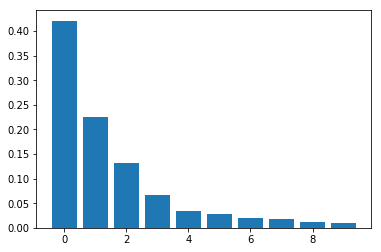

In [149]:
gcpol = getg(mcpol)

In [150]:
bias(gcpol, mcpol, proflist)

0.5980368159429239

In [151]:
words_cpol = []
for s in controls_pol:
    words_cpol += nltk.word_tokenize(s)
len(words_cpol)

2424360

In [152]:
sums_pol = []
for s in summaries_pol:
    sums_pol += nltk.sent_tokenize(s)
len(sums_pol)

72051

In [153]:
words_spol = []
for s in sums_pol:
    words_spol += nltk.word_tokenize(s)
len(words_spol)

3421655

In [154]:
words_pol = []
for p in politics:
    words_pol += nltk.word_tokenize(p.text)
len(words_pol)

10682577

In [164]:
t = time.process_time()
wcontrols_pol = []
count = 0
tot = 0
for i in range(len(politics)):
    if i in [1008, 1938, 4466, 6292, 7783, 8379, 9505, 10035]:
        continue
    # get number of words in the summary
    n = len(nltk.word_tokenize(summaries_pol[count]))
    tot += n
    sents = nltk.sent_tokenize(politics[i].text)
    wcount = 0
    wtot = len(nltk.word_tokenize(politics[i].text))
    start = randint(0, wtot-n)
    end = start + n
    started = False
    for s in sents:
        w = nltk.word_tokenize(s)
        wcount += len(w)
        if wcount < start:
            continue
        elif started is False:  
            wcontrols_pol.append(w[max(0, start-wcount+len(w)-1):])
            started = True
        elif wcount > end:
            wcontrols_pol.append(w[:min(len(w), len(w)-wcount+end+1)])
            break
        else:
            wcontrols_pol.append(w)
    # get n-word consecutive subset of original text
    count += 1
time.process_time() - t

145.02573600000005

In [165]:
swcontrols_pol = [" ".join(x) for x in wcontrols_pol]
print(tot, sum([len(x) for x in wcontrols_pol]))

3421595 3458033


In [166]:
t = time.process_time()
docs = [simple_preprocess(s) for s in swcontrols_pol]
mwcpol = Word2Vec(docs)
time.process_time() - t

105.49074400000018

(66, 100)


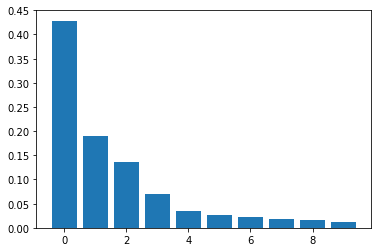

In [159]:
gwcpol = getg(mwcpol)

In [161]:
bias(gwcpol, mwcpol, proflist), bias(gpols, mpols, proflist)

(0.5949498666298728, 0.7235289508241887)

In [162]:
regress(gpols, mpols, gwcpol, mwcpol, proflist)

(-0.76112853809404, 9.301110161945145e-40)

In [163]:
regress(gpol, mpol, gcomp, mcomp, proflist)

(0.28612796610067653, 1.936121103526654e-16)

## Centroid Summarization

In [317]:
t = time.process_time()
wcentroids_pol = []
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
count = 0
tot = 0
for i in range(len(politics)):
    if i in [1008, 1938, 4466, 6292, 7783, 8379, 9505, 10035]:
        continue
    # get number of words in the summary
    n = len(summaries_pol[count].split())
    tot += n
    centroid_summary = centroid_summarizer.summarize(politics[i].text, limit=n-20)
    wcentroids_pol.append(centroid_summary)
    count += 1
time.process_time() - t

192.68935299999976

In [248]:
summaries_pol[0]

"Usually scrip loses value over time in what some economists call a ''backdoor devaluation.''By ceasing payment on the debt, Mr. Rodríguez Saá can save the government as much as $10 billion or more next year, although Argentina is likely to be shut out of international financial markets for years to come.Of the $132 billion owed by the government, about $45 billion is in bonds owed to foreign lenders, with the rest owed to domestic banks and pension funds and international lending institutions like the International Monetary Fund and the World Bank.With the central government in default, the 24 provinces are almost certain to default on their $22 billion in total debts as well.The de la Rúa government had already cut interest rate payments on domestically held bonds and had failed to pay any interest on several bonds in its final days in office.The next president will be chosen in March by a peculiar system that combines party primaries and the general election.\n''How can a president 

In [253]:
mpols_centroid = getw2v_s(wcentroids_pol)

(62, 100)


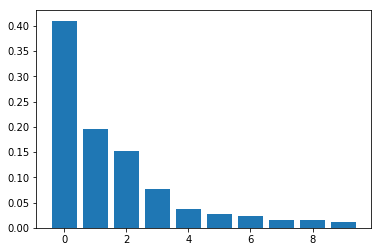

In [254]:
gpols_centroid = getg(mpols_centroid)

In [255]:
len(mpols_centroid.wv.vocab), len(mpols.wv.vocab)

(20434, 20864)

In [256]:
bias(gpols, mpols, proflist), bias(gpols_centroid, mpols_centroid, proflist)

(0.6022038179460508, 0.42971444262143105)

In [257]:
bias(gpols, mpols, adjectives), bias(gpols_centroid, mpols_centroid, adjectives)

(0.2697019369034747, 0.20419365736623168)

In [258]:
bias(gpols, mpols, gender_specific), bias(gpols_centroid, mpols_centroid, gender_specific)

(0.7581410895366378, 1.3411041270310817)

In [230]:
len(wcentroids_pol)

10308

In [390]:
t = time.process_time()
wcentroids_comp = []
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
count = 0
tot = 0
for i in range(len(computers)):
    if i in [1018, 1258, 1830, 3182, 3296, 4812, 5102]:
        continue
    # get number of words in the summary
    n = len(summaries_comp[count].split())
    tot += n
    centroid_summary = centroid_summarizer.summarize(computers[i].text, limit=n-20)
    wcentroids_comp.append(centroid_summary)
    count += 1
time.process_time() - t

125.37619600000107

In [438]:
mcomp_centroid = getw2v_s(wcentroids_comp)

(56, 100)


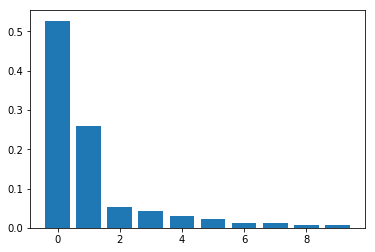

In [439]:
gcomp_centroid = getg(mcomp_centroid)

In [277]:
print(bias(gcomp, mcomp, proflist), bias(gcomp_centroid, mcomp_centroid, proflist))
print(bias(gcomp, mcomp, adjectives), bias(gcomp_centroid, mcomp_centroid, adjectives))
print(bias(gcomp, mcomp, gender_specific), bias(gcomp_centroid, mcomp_centroid, gender_specific))

0.7463272172571751 0.3828250152105927
0.2941469405449194 0.2100886114036033
1.4981401158066685 1.05599696174761


In [274]:
t = time.process_time()
wcentroids_trav = []
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
count = 0
tot = 0
for i in range(len(travel)):
    # get number of words in the summary
    n = len(summaries_trav[count].split())
    tot += n
    centroid_summary = centroid_summarizer.summarize(travel[i].text, limit=n-20)
    wcentroids_trav.append(centroid_summary)
    count += 1
time.process_time() - t

174.44324300000062

(66, 100)


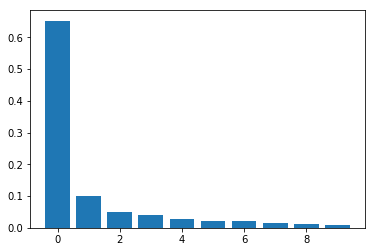

In [276]:
mtrav_centroid = getw2v_s(wcentroids_trav)
gtrav_centroid = getg(mtrav_centroid)

In [279]:
print(bias(gtrav, mtrav, proflist), bias(gtrav_centroid, mtrav_centroid, proflist))
print(bias(gtrav, mtrav, adjectives), bias(gtrav_centroid, mtrav_centroid, adjectives))
print(bias(gtrav, mtrav, gender_specific), bias(gtrav_centroid, mtrav_centroid, gender_specific))

0.4574666229162467 0.14840945387813959
0.38416117312045955 0.20948081964275841
1.318271033219984 0.9624721782705774


In [278]:
len(politics), len(travel), len(computers)

(10316, 6499, 5825)

## Controlling for number of articles

In [280]:
from random import sample

In [281]:
def getw2v2(category, size):
    sentences = []
    category = sample(category, size)
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return category, Word2Vec(docs)

In [367]:
politics5825, mpol5825 = getw2v2(politics, 5835)

In [368]:
travel5825, mtrav5825 = getw2v2(travel, 5825)

In [369]:
t = time.process_time()
summaries_pol5825 = getsummaries(politics5825)
time.process_time() - t

1964
4403
5522


79.0963469999997

In [419]:
t = time.process_time()
mpols5825 = getw2v_s(summaries_pol5825)
time.process_time() - t

24.919758

In [371]:
t = time.process_time()
summaries_trav5825 = getsummaries(travel5825)
time.process_time() - t

115.66957399999956

In [372]:
t = time.process_time()
mtravs5825 = getw2v_s(summaries_trav5825)
time.process_time() - t

29.37724099999923

In [373]:
t = time.process_time()
wcentroids_pol5825 = []
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
count = 0
tot = 0
for i in range(len(politics5825)):
    if i in [708,819,1222,1723,1966,3569,4924]:
        continue
    # get number of words in the summary
    n = len(summaries_pol5825[count].split())
    tot += n
    centroid_summary = centroid_summarizer.summarize(politics5825[i].text, limit=n-20)
    wcentroids_pol5825.append(centroid_summary)
    # get n-word consecutive subset of original text
    count += 1
time.process_time() - t

104.3283020000008

In [374]:
t = time.process_time()
wcentroids_trav5825 = []
centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
count = 0
tot = 0
for i in range(len(travel5825)):
    # get number of words in the summary
    n = len(summaries_trav5825[count].split())
    tot += n
    centroid_summary = centroid_summarizer.summarize(travel5825[i].text, limit=n-20)
    wcentroids_trav5825.append(centroid_summary)
    count += 1
time.process_time() - t

136.33851400000094

In [405]:
def getsummaries2(ctrlsums, summarizer, exclude, category):
    ret = []
    count = 0
    tot = 0
    for i in range(len(category)):
        if i in exclude:
            continue
        # get number of words in the summary
        n = len(ctrlsums[count].split())
        tot += n
        summary = summarizer.summarize(category[i].text, limit=n-20)
        ret.append(summary)
        count += 1
    return ret

In [420]:
t = time.process_time()
pols_centroidwe = getsummaries2(summaries_pol5825, centroid_word_embedding_summarizer, [708,819,1222,1723,1966,3569,4924], politics5825)
time.process_time() - t


157.77177200000006

In [407]:
t = time.process_time()
comps_centroidwe = getsummaries2(summaries_comp, centroid_word_embedding_summarizer, [1018,1258,1830,3182,3296,4812,5102], computers)
time.process_time() - t


181.4955230000014

In [409]:
t = time.process_time()
travs_centroidwe = getsummaries2(summaries_trav, centroid_word_embedding_summarizer, [], travel)
time.process_time() - t


265.2924570000014

In [426]:
mpols_centroidwe = getw2v_s(pols_centroidwe)

In [412]:
mpols_centroidwe = getw2v_s(pols_centroidwe)
mcomps_centroidwe = getw2v_s(comps_centroidwe)
mtravs_centroidwe = getw2v_s(travs_centroidwe)

(44, 100)


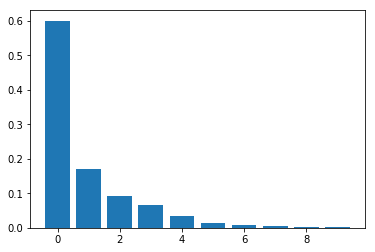

In [427]:
gpols_centroidwe = getg(mpols_centroidwe)

(44, 100)


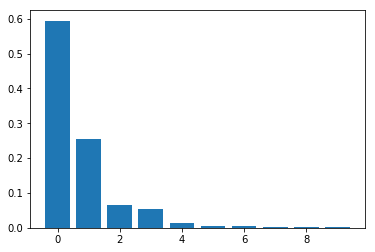

In [414]:
gcomps_centroidwe = getg(mcomps_centroidwe)

(62, 100)


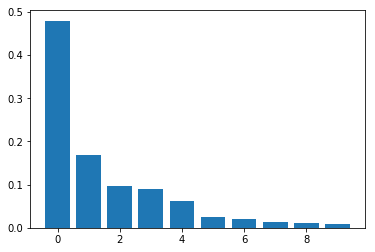

In [416]:
gtravs_centroidwe = getg(mtravs_centroidwe)

In [375]:
t = time.process_time()
mpols_centroid5825 = getw2v_s(wcentroids_pol5825)
time.process_time() - t

20.39487900000131

In [376]:
t = time.process_time()
mtravs_centroid5825 = getw2v_s(wcentroids_trav5825)
time.process_time() - t

28.562599999999293

(74, 100)


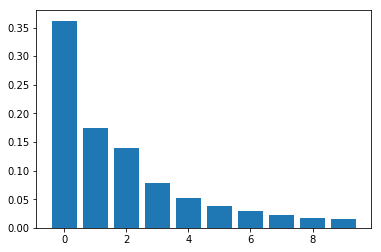

In [422]:
gpol5825 = getg(mpol5825)

(84, 100)


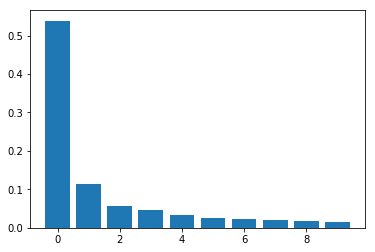

In [378]:
gtrav5825 = getg(mtrav5825)

(58, 100)


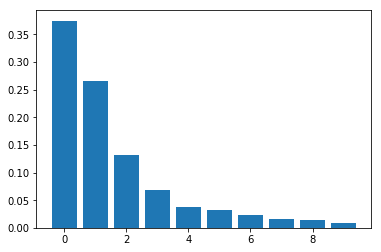

In [421]:
gpols5825 = getg(mpols5825)

(62, 100)


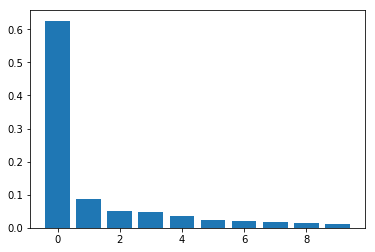

In [380]:
gtravs5825 = getg(mtravs5825)

(56, 100)


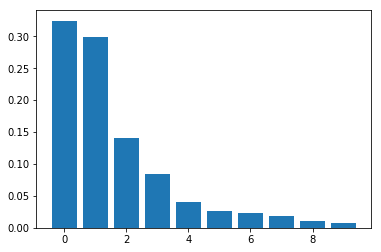

In [381]:
gpols_centroid5825 = getg(mpols_centroid5825)

(66, 100)


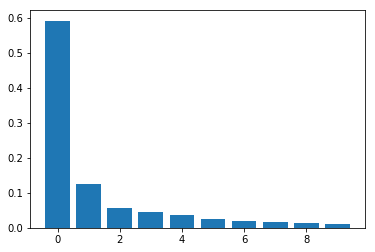

In [382]:
gtravs_centroid5825 = getg(mtravs_centroid5825)

In [417]:
def testbiaslen(wordlist):
    print(f"politics: {bias(gpol5825, mpol5825, wordlist)}")
    print(f"politics summary (textrank): {bias(gpols5825, mpols5825, wordlist)}")
    print(f"politics summary (centroid BOW): {bias(gpols_centroid5825, mpols_centroid5825, wordlist)}")
    print(f"politics summary (centroid WE): {bias(gpols_centroidwe, mpols_centroidwe, wordlist)}")
    print(f"computers: {bias(gcomp, mcomp, wordlist)}")
    print(f"computers summary: {bias(gcomps, mcomps, wordlist)}")
    print(f"computers summary (centroid BOW): {bias(gcomp_centroid, mcomp_centroid, wordlist)}")
    print(f"computers summary (centroid WE): {bias(gcomps_centroidwe, mcomps_centroidwe, wordlist)}")
    print(f"travel: {bias(gtrav5825, mtrav5825, wordlist)}")
    print(f"travel summary: {bias(gtravs5825, mtravs5825, wordlist)}")
    print(f"travel summary (centroid BOW): {bias(gtravs_centroid5825, mtravs_centroid5825, wordlist)}")
    print(f"travel summary (centroid WE): {bias(gtravs_centroidwe, mtravs_centroidwe, wordlist)}")

In [440]:
testbiaslen(proflist)

politics: 0.7335234985533784
politics summary (textrank): 0.6574114762552342
politics summary (centroid BOW): 1.2824995217263468
politics summary (centroid WE): 1.8274917926411358
computers: 0.7212840233313105
computers summary: 0.450853504622297
computers summary (centroid BOW): 0.52871358749296
computers summary (centroid WE): 1.8170225428357671
travel: 0.41171318892622766
travel summary: 0.12071090081225919
travel summary (centroid BOW): 0.15780635587430647
travel summary (centroid WE): 0.5584299267286956


In [434]:
len(ms_centroid.wv.vocab)

13744